# Earthquake Catalog Workshop

Contributors: Eric Beauce, Gabrielle Tepp, Clara Yoon, Ellen Yu, Weiqiang Zhu 
(alphabetical order)

## Machine Learning Part

1. Download data using Obpsy and NCEDC/SCEDC AWS Public Dataset 

    [FDSN web service client for ObsPy](https://docs.obspy.org/packages/obspy.clients.fdsn.html#module-obspy.clients.fdsn)

    [NCEDC AWS Public Dataset](https://ncedc.org/db/cloud/getstarted-pds.html)

    [SCEDC AWS Public Dataset](https://scedc.caltech.edu/data/getstarted-pds.html)

    [Event Dataset (CEED)](https://huggingface.co/datasets/AI4EPS/CEED)

    [CEED paper](https://arxiv.org/pdf/2502.11500v1)
    
2. PhaseNet for P/S phase picking

    [PhaseNet github page](https://github.com/AI4EPS/PhaseNet/)

    [PhaseNet paper](https://arxiv.org/abs/1803.03211)

3. GaMMA for phase association

    [GaMMA github page](https://github.com/AI4EPS/GaMMA/)

    [GaMMA paper](https://arxiv.org/abs/2109.09008)
    
4. ADLoc for earthquake location

    [ADLoc github page](https://github.com/AI4EPS/ADLoc)

    [ADLoc paper](https://arxiv.org/abs/2502.10933v1)

5. HypoDD for earthquake relocation

    [HypoDD github page](https://github.com/fwaldhauser/HypoDD)

    [HypoDD paper](https://www.ldeo.columbia.edu/~felixw/papers/Waldhauser_OFR2001.pdf)

6. QuakeFlow

    [QuakeFlow github page](https://github.com/AI4EPS/QuakeFlow)

    [QuakeFlow paper](https://arxiv.org/abs/2208.14564)
    



### Setup Environment

In [23]:
# !conda env create -f env.yaml --prefix .conda/quakeflow
# !source activate .conda/quakeflow
# !git clone --recursive https://github.com/AI4EPS/QuakeFlow.git notebooks/QuakeFlow/
# !cd notebooks/QuakeFlow/PhaseNet && git checkout master && cd ../
# !python -m pip install -U git+https://github.com/AI4EPS/GaMMA.git
# !python -m pip install -U git+https://github.com/AI4EPS/ADLoc.git

In [2]:
# %%
import json
import os
import pickle
from collections import defaultdict
from datetime import datetime
from typing import Dict
from glob import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import obspy
import obspy.clients.fdsn
import pandas as pd
from obspy.clients.fdsn.mass_downloader import (
    CircularDomain,
    MassDownloader,
    Restrictions,
)
from pyproj import Proj
from tqdm import tqdm

from adloc.eikonal2d import init_eikonal2d
from adloc.sacloc2d import ADLoc
from adloc.utils import invert_location
from gamma.utils import association, estimate_eps


### Setup configurations

In [4]:
def set_config(root_path: str = "local", region: str = "demo") -> Dict:

    if not os.path.exists(f"{root_path}/{region}"):
        os.makedirs(f"{root_path}/{region}", exist_ok=True)

    regions = {
            "demo": {
                "longitude0": -117.504,
                "latitude0": 35.705,
                "maxradius_degree": 0.5,
                "mindepth": 0,
                "maxdepth": 30,
                "starttime": "2019-07-04T00:00:00",
                "endtime": "2019-07-05T00:00:00",
                "network": "CI",
                "channel": "HH*,BH*,EH*,HN*",
                "provider": [
                    "SCEDC"
                ],
            },
            "ridgecrest": {
                "longitude0": -117.504,
                "latitude0": 35.705,
                "maxradius_degree": 1.0,
                "mindepth": 0,
                "maxdepth": 30,
                "starttime": "2019-07-04T00:00:00",
                "endtime": "2019-07-10T00:00:00",
                "network": "CI",
                "channel": "HH*,BH*,EH*,HN*",
                "provider": [
                    "SCEDC"
                ],
            },
    }

    ## Set config
    config = regions[region.lower()]

    ## PhaseNet
    config["phasenet"] = {}
    ## GaMMA
    config["gamma"] = {}
    ## ADLoc
    config["adloc"] = {}
    ## HypoDD
    config["hypodd"] = {}

    with open(f"{root_path}/{region}/config.json", "w") as fp:
        json.dump(config, fp, indent=2)

    print(json.dumps(config, indent=4))

    return config

In [5]:
region = "demo"
config  = set_config(region = region)

{
    "longitude0": -117.504,
    "latitude0": 35.705,
    "maxradius_degree": 0.5,
    "mindepth": 0,
    "maxdepth": 30,
    "starttime": "2019-07-04T00:00:00",
    "endtime": "2019-07-05T00:00:00",
    "network": "CI",
    "channel": "HH*,BH*,EH*,HN*",
    "provider": [
        "SCEDC"
    ],
    "phasenet": {},
    "gamma": {},
    "adloc": {},
    "hypodd": {}
}


### Download the standard catalog for comparison

In [24]:
def plot_catalog(catalog: pd.DataFrame, method="Standard", region: str = "demo", config: Dict = {}):
    ## Plot earthquake locations
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.2)

    scatter = ax.scatter(
        catalog['longitude'],
        catalog['latitude'],
        c=catalog['depth_km'],
        cmap='viridis_r',
        s=1,
        alpha=0.6,
        vmin = config["mindepth"],
        vmax = config["maxdepth"]/2,
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(scatter, label='Depth (km)')
    ax.set_extent([config["longitude0"] - config["maxradius_degree"]/2, config["longitude0"] + config["maxradius_degree"]/2, config["latitude0"] - config["maxradius_degree"]/2, config["latitude0"] + config["maxradius_degree"]/2])

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.title(f'{method} Catalog ({len(catalog)})')
    plt.show()

def plot_stations(stations: pd.DataFrame, catalog: pd.DataFrame=None, region: str = "demo", config: Dict = {}):
    ## Plot earthquake locations
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.2)

    scatter = ax.scatter(
        stations['longitude'],
        stations['latitude'],
        c="C0",
        s=40,
        marker="^",
        alpha=0.6,
        transform=ccrs.PlateCarree()
    )
    if catalog is not None:
        scatter = ax.scatter(
            catalog['longitude'],
            catalog['latitude'],
            c=catalog['depth_km'],
            cmap='viridis_r',
            s=1,
            alpha=0.6,
            vmin = config["mindepth"],
            vmax = config["maxdepth"]/2,
            transform=ccrs.PlateCarree()
        )
        plt.colorbar(scatter, label='Depth (km)')
    ax.set_extent([config["longitude0"] - config["maxradius_degree"], config["longitude0"] + config["maxradius_degree"], config["latitude0"] - config["maxradius_degree"], config["latitude0"] + config["maxradius_degree"]])

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.title(f'Stations ({len(stations["station"].unique())})')
    plt.show()

def download_catalog(root_path: str = "local", region: str = "demo", config: Dict = {}):

    result_path = f"{region}/obspy"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")
    # print(json.dumps(config, indent=4))

    ## Download catalog 
    client = obspy.clients.fdsn.Client("usgs")
    events = client.get_events(
        starttime=config["starttime"],
        endtime=config["endtime"],
        latitude=config["latitude0"],
        longitude=config["longitude0"],
        maxradius=config["maxradius_degree"],
    )
    print(f"Number of events: {len(events)}")

    ## Save catalog
    catalog = defaultdict(list)
    for event in events:
        if len(event.magnitudes) > 0:
            catalog["time"].append(event.origins[0].time.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f"))
            catalog["magnitude"].append(event.magnitudes[0].mag)
            catalog["longitude"].append(event.origins[0].longitude)
            catalog["latitude"].append(event.origins[0].latitude)
            catalog["depth_km"].append(event.origins[0].depth/1e3)
    catalog = pd.DataFrame.from_dict(catalog).sort_values(["time"])
    catalog.to_csv(f"{root_path}/{result_path}/catalog.csv", index=False)

    return catalog

Number of events: 709


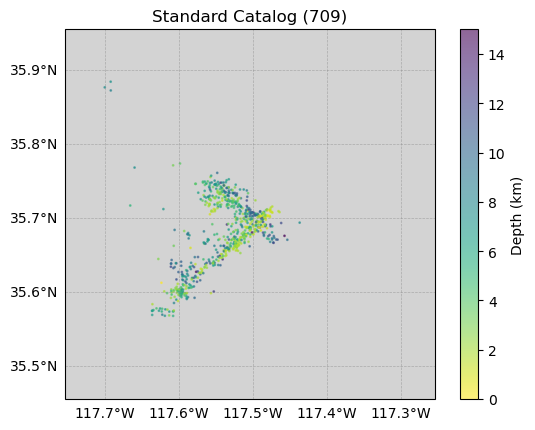

In [7]:
standard_catalog = download_catalog(region=region, config=config)
plot_catalog(standard_catalog, method="Standard", config=config)

### Download stations

In [8]:
def download_station(root_path: str = "local", region: str = "demo", config: Dict = {}):

    result_dir = f"{region}/obspy"
    if not os.path.exists(f"{root_path}/{result_dir}"):
        os.makedirs(f"{root_path}/{result_dir}")
    if not os.path.exists(f"{root_path}/{result_dir}/inventory/"):
        os.makedirs(f"{root_path}/{result_dir}/inventory/")

    ## Download stations
    stations = obspy.core.inventory.Inventory()
    for provider in config["provider"]:
        client = obspy.clients.fdsn.Client(provider)
        stations += client.get_stations(
                network=config["network"],
                station="*",
                starttime=config["starttime"],
                endtime=config["endtime"],
                latitude=config["latitude0"],
                longitude=config["longitude0"],
                maxradius=config["maxradius_degree"],
                channel=config["channel"],
                level="response",
            )
    stations.write(f"{root_path}/{result_dir}/inventory.xml", format="STATIONXML")
    print("Number of stations: {}".format(sum([len(x) for x in stations])))

    ## Save stations
    station_dict = defaultdict(dict)
    for network in stations:
        for station in network:
            inv = stations.select(network=network.code, station=station.code)
            inv.write(f"{root_path}/{result_dir}/inventory/{network.code}.{station.code}.xml", format="STATIONXML")
            for channel in station:
                sid = f"{network.code}.{station.code}.{channel.location_code}.{channel.code}"
                station_dict[sid] = {
                    "network": network.code,
                    "station": station.code,
                    "location": channel.location_code,
                    "channel": channel.code,
                    "longitude": channel.longitude,
                    "latitude": channel.latitude,
                    "elevation_m": channel.elevation,
                    "response": round(channel.response.instrument_sensitivity.value, 2),
                }

    # with open(f"{root_path}/{result_dir}/stations.json", "w") as fp:
    #     json.dump(station_dict, fp, indent=2)

    with open(f"{root_path}/{result_dir}/stations.pkl", "wb") as fp:
        pickle.dump(stations, fp)

    stations = pd.DataFrame.from_dict(station_dict, orient="index")
    stations.to_csv(f"{root_path}/{result_dir}/stations.csv", index=False)
        
    return stations

Number of stations: 15


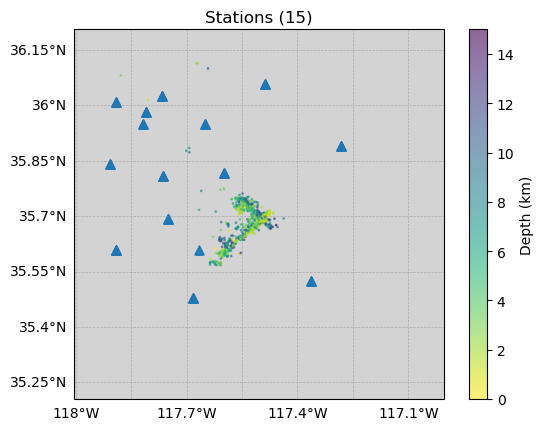

In [9]:
stations = download_station(region=region, config=config)
plot_stations(stations, catalog = standard_catalog, region=region, config=config)

### Download waveform data

In [ ]:
def map_remote_path(provider, bucket, starttime, network, station, location, channel):

    starttime = pd.Timestamp(starttime).round("h").to_pydatetime()  # in case of 2021-01-01T23:59:xxx
    if provider.lower() == "scedc":
        year = starttime.strftime("%Y")
        dayofyear = starttime.strftime("%j")
        if location == "":
            location = "__"
        path = f"s3://{bucket}/{year}/{year}_{dayofyear}/{network}{station:_<5}{channel}{location:_<2}_{year}{dayofyear}.ms"
    elif provider.lower() == "ncedc":
        year = starttime.strftime("%Y")
        dayofyear = starttime.strftime("%j")
        path = f"s3://{bucket}/{network}/{year}/{year}.{dayofyear}/{station}.{network}.{channel}.{location}.D.{year}.{dayofyear}"
    else:
        raise ValueError(f"Unknown provider: {provider}")
    return path

def download_waveform(root_path: str = "local", region: str = "demo", config: Dict = {}):

    waveform_dir = f"{region}/waveforms"
    if not os.path.exists(f"{root_path}/{waveform_dir}"):
        os.makedirs(f"{root_path}/{waveform_dir}")
    # print(json.dumps(config, indent=4))

    ## Download from cloud
    for provider in config["provider"]:
        if provider.lower() in ["scedc", "ncedc"]:
            cloud = {
                "provider": provider.lower(),
                "bucket": f"{provider.lower()}-pds/continuous_waveforms",
            }

        DELTATIME = "1D"
        starttime = datetime.fromisoformat(config["starttime"]).strftime("%Y-%m-%d")
        starttimes = pd.date_range(starttime, config["endtime"], freq=DELTATIME, tz="UTC", inclusive="left").to_list()
        # with open(f'{root_path}/{region}/obspy/stations.json', 'r') as f:
        #     stations = json.load(f)
        stations = pd.read_csv(f"{root_path}/{region}/obspy/stations.csv", na_filter=False)
        stations["instrument"] = stations['channel'].apply(lambda x: x[:-1])
        stations["component"] = stations['channel'].apply(lambda x: x[-1])
        location_priorities = ('', '00', '10', '01', '20', '02', '30', '03', '40', '04', 
                              '50', '05', '60', '06', '70', '07', '80', '08', '90', '09')
        location_priority_map = {loc: i for i, loc in enumerate(location_priorities)}
        instrument_priorities = ('HH', 'BH', 'MH', 'EH', 'LH', 'HL', 'BL', 'ML', 'EL', 'LL', 'SH')
        instrument_priority_map = {ch: i for i, ch in enumerate(instrument_priorities)}
        component_priorities = ('E', 'N', 'Z', '1', '2', '3')
        component_priority_map = {ch: i for i, ch in enumerate(component_priorities)}
        stations['location_priority'] = stations['location'].map(location_priority_map)
        stations['instrument_priority'] = stations['instrument'].apply(lambda x: instrument_priority_map.get(x, len(instrument_priorities)))
        stations['component_priority'] = stations['component'].apply(lambda x: component_priority_map.get(x, len(component_priorities)))
        stations.sort_values(['network', 'station', 'location_priority', 'instrument_priority', "component_priority"], inplace=True)
        stations.drop(['location_priority', 'instrument_priority', 'component_priority'], axis=1, inplace=True)

        for starttime in starttimes:
            for _, station in tqdm(stations.groupby(["network", "station"]), desc=f"Downloading {starttime}"):
                prev = ""
                nch = set()
                for _, row in station.iterrows():
                    if len(nch) >= 3:
                        break
                    network, station, location, channel, instrument = row["network"], row["station"], row["location"], row["channel"], row["instrument"]
                    if instrument != prev:
                        prev = instrument
                        nch = set()
                    mseed_path = map_remote_path(
                        cloud["provider"],
                        cloud["bucket"],
                        starttime,
                        network,
                        station,
                        location,
                        channel,
                    )
                    try:
                        if os.path.exists(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed"):
                            # print(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed downloaded.")
                            nch.add(channel[-1])
                            continue
                        if not os.path.exists(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}"):
                            os.makedirs(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}")
                        with fsspec.open(f"{mseed_path}", "rb", s3={"anon": True}) as f:
                            data = f.read()
                        with open(f"{root_path}/{waveform_dir}/{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed", "wb") as f:
                            f.write(data)
                            nch.add(channel[-1])
                    except Exception as e:
                        print(f"Failed to download {e}")
                        pass
                    print(f"{len(nch) = } {instrument = }")

    # %% Download from FDSN
    domain = CircularDomain(
        longitude=config["longitude0"],
        latitude=config["latitude0"],
        minradius=0,
        maxradius=config["maxradius_degree"],
    )

    restrictions = Restrictions(
        starttime=obspy.UTCDateTime(config["starttime"]),
        endtime=obspy.UTCDateTime(config["endtime"]),
        chunklength_in_sec=3600 * 24, # 1 day
        network=config["network"] if "network" in config else None,
        station=config["station"] if "station" in config else None,
        minimum_interstation_distance_in_m=0,
        minimum_length=0.1,
        reject_channels_with_gaps=False,
    )

    def get_mseed_storage(network, station, location, channel, starttime, endtime):
        mseed_name = f"{starttime.strftime('%Y/%j')}/{network}.{station}.{location}.{channel}.mseed"
        if os.path.exists(f"{root_path}/{waveform_dir}/{mseed_name}"):
            # print(f"{root_path}/{waveform_dir}/{mseed_name} downloaded.")
            return True
        return f"{root_path}/{waveform_dir}/{mseed_name}"

    mdl = MassDownloader(
        providers=config["provider"],
        # providers=["IRIS"],
    )
    mdl.download(
        domain,
        restrictions,
        mseed_storage=get_mseed_storage,
        stationxml_storage=f"{root_path}/{waveform_dir}/stations",
        download_chunk_size_in_mb=20,
        threads_per_client=1,
        print_report=False,
    )
    
    return


In [11]:
download_waveform(region=region, config=config)

[2025-04-07 04:47:58,774] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for SCEDC.
[2025-04-07 04:47:58,776] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): SCEDC.
[2025-04-07 04:47:58,777] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2025-04-07 04:47:58,778] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Requesting unreliable availability.


Failed to download scedc-pds/continuous_waveforms/2019/2019_185/CIQ0072HNE01_2019185.ms
len(nch) = 0 instrument = 'HN'
Failed to download scedc-pds/continuous_waveforms/2019/2019_185/CIQ0072HNN01_2019185.ms
len(nch) = 0 instrument = 'HN'
Failed to download scedc-pds/continuous_waveforms/2019/2019_185/CIQ0072HNZ01_2019185.ms
len(nch) = 0 instrument = 'HN'


[2025-04-07 04:47:58,998] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - No data available for request.
[2025-04-07 04:47:58,999] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - No data available.


### Run PhaseNet to pick P/S picks

<img src="https://raw.githubusercontent.com/zhuwq0/images/main/202504062230905.png" style="width:50%;">

In [12]:
def run_phasenet(root_path: str = "local", region: str = "demo", config: Dict = {} ) -> str:

    result_path = f"{region}/phasenet"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")

    # %%
    waveform_dir = f"{region}/waveforms"
    mseed_list = sorted(glob(f"{root_path}/{waveform_dir}/????/???/*.mseed"))

    # %% group 3C channels
    mseed_list = sorted(list(set([x.split(".mseed")[0][:-1] + "*.mseed" for x in mseed_list])))

    # %%
    with open(f"{root_path}/{result_path}/mseed_list.csv", "w") as fp:
        fp.write("fname\n")
        fp.write("\n".join(mseed_list))

    # %%
    model_path = "QuakeFlow/PhaseNet/"
    cmd = f"python {model_path}/phasenet/predict.py --model={model_path}/model/190703-214543 --data_dir=./ --data_list={root_path}/{result_path}/mseed_list.csv --response_xml={root_path}/{region}/obspy/inventory.xml --format=mseed --amplitude --highpass_filter=1.0 --result_dir={root_path}/{result_path} --result_fname=phasenet_picks --batch_size=1"
    # cmd += " --sampling_rate 100" 
    os.system(cmd)

    return f"{root_path}/{result_path}/phasenet_picks.csv"


In [13]:
phasenet_picks = run_phasenet(region=region, config=config)

2025-04-07 04:47:59.379766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 04:48:01,380 Pred log: local/demo/phasenet
2025-04-07 04:48:01,380 Dataset size: 17
2025-04-07 04:48:01.434276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 04:48:01.435718: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for 

Done with 14088 P-picks and 14637 S-picks


### Run GaMMA to associate P/S picks

<img src="https://raw.githubusercontent.com/zhuwq0/images/main/202504062233284.png" style="width:50%;">

In [14]:
def run_gamma(root_path: str = "local", region: str = "demo", config: Dict = {}):

    data_path = f"{region}/phasenet"
    result_path = f"{region}/gamma"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")

    picks_csv = f"{data_path}/phasenet_picks.csv"
    gamma_events_csv = f"{result_path}/gamma_events.csv"
    gamma_picks_csv = f"{result_path}/gamma_picks.csv"
    station_json = f"{region}/obspy/stations.json"

    ## read picks
    picks = pd.read_csv(f"{root_path}/{picks_csv}")
    picks.drop(columns=["event_index"], inplace=True, errors="ignore")
    picks["id"] = picks["station_id"]
    picks["timestamp"] = picks["phase_time"]
    picks["amp"] = picks["phase_amplitude"]
    picks["type"] = picks["phase_type"]
    picks["prob"] = picks["phase_score"]

    ## read stations
    stations = pd.read_json(f"{root_path}/{station_json}", orient="index")
    stations["id"] = stations.apply(lambda x: f"{x['network']}.{x['station']}.{x['location']}.{x['channel'][:-1]}", axis=1)
    stations = stations.groupby("id").agg(lambda x: x.iloc[0] if len(set(x)) == 1 else sorted(list(x))).reset_index()
    proj = Proj(f"+proj=sterea +lon_0={config['longitude0']} +lat_0={config['latitude0']} +units=km")
    stations[["x(km)", "y(km)"]] = stations.apply(
        lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1
    )
    stations["z(km)"] = stations["elevation_m"].apply(lambda x: -x / 1e3)
    # print(stations.to_string())

    ## setting GaMMA configs
    config["use_dbscan"] = True
    config["use_amplitude"] = True
    config["method"] = "BGMM"
    if config["method"] == "BGMM":  ## BayesianGaussianMixture
        config["oversample_factor"] = 5
    if config["method"] == "GMM":  ## GaussianMixture
        config["oversample_factor"] = 1

    # earthquake location
    config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}
    config["dims"] = ["x(km)", "y(km)", "z(km)"]
    minlat, maxlat = config["latitude0"] - config["maxradius_degree"], config["latitude0"] + config["maxradius_degree"]
    minlon, maxlon = config["longitude0"] - config["maxradius_degree"], config["longitude0"] + config["maxradius_degree"]
    xmin, ymin = proj(minlon, minlat)
    xmax, ymax = proj(maxlon, maxlat)
    # zmin, zmax = config["mindepth"], config["maxdepth"]
    zmin = config["mindepth"] if "mindepth" in config else 0
    zmax = config["maxdepth"] if "maxdepth" in config else 30
    config["x(km)"] = (xmin, xmax)
    config["y(km)"] = (ymin, ymax)
    config["z(km)"] = (zmin, zmax)
    config["bfgs_bounds"] = (
        (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
        (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
        (0, config["z(km)"][1] + 1),  # z
        (None, None),  # t
    )

    # DBSCAN
    config["dbscan_eps"] = estimate_eps(stations, config["vel"]["p"])  # s
    config["dbscan_min_samples"] = 3

    ## Eikonal for 1D velocity model
    zz = [0.0, 5.5, 5.5, 16.0, 16.0, 32.0, 32.0]
    vp = [5.5, 5.5, 6.3, 6.3, 6.7, 6.7, 7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    h = 0.3
    vel = {"z": zz, "p": vp, "s": vs}
    config["eikonal"] = {"vel": vel, "h": h, "xlim": config["x(km)"], "ylim": config["y(km)"], "zlim": config["z(km)"]}

    # filtering
    config["min_picks_per_eq"] = 5
    config["min_p_picks_per_eq"] = 0
    config["min_s_picks_per_eq"] = 0
    config["max_sigma11"] = 2.0  # s
    config["max_sigma22"] = 1.0  # log10(m/s)
    config["max_sigma12"] = 1.0  # covariance

    ## filter picks without amplitude measurements
    if config["use_amplitude"]:
        picks = picks[picks["amp"] != -1]

    # for k, v in config.items():
    #     print(f"{k}: {v}")

    print(f"Number of picks: {len(picks)}")

    # %%
    event_idx0 = 0  ## current earthquake index
    assignments = []
    events, assignments = association(picks, stations, config, event_idx0, config["method"])

    if len(events) == 0:
        return 
    
    ## create catalog
    events = pd.DataFrame(events)
    events[["longitude", "latitude"]] = events.apply(
        lambda x: pd.Series(proj(longitude=x["x(km)"], latitude=x["y(km)"], inverse=True)), axis=1
    )
    events["depth_km"] = events["z(km)"]
    events.sort_values("time", inplace=True)
    with open(f"{root_path}/{gamma_events_csv}", "w") as fp:
        events.to_csv(fp, index=False, float_format="%.3f", date_format="%Y-%m-%dT%H:%M:%S.%f")
    ## add assignment to picks
    assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])
    picks = picks.join(assignments.set_index("pick_index")).fillna(-1).astype({"event_index": int})
    picks.sort_values(["phase_time"], inplace=True)
    with open(f"{root_path}/{gamma_picks_csv}", "w") as fp:
        picks.to_csv(fp, index=False, date_format="%Y-%m-%dT%H:%M:%S.%f")

    # return f"{root_path}/{result_path}/gamma_picks.csv", f"{root_path}/{result_path}/gamma_events.csv"
    return events


In [15]:
gamma_catalog = run_gamma(region=region, config=config)

Number of picks: 28725
Eikonal Solver: 
Iter 0, error = 999.945
Iter 1, error = 0.000
Time: 2.403
Eikonal Solver: 
Iter 0, error = 999.906
Iter 1, error = 0.000
Time: 0.046
Associating 637 clusters with 3 CPUs
........................................................
Associated 100 events
....................................................
Associated 200 events
.
Initialization 1 did not converge.
.........................................
Associated 300 events
................................................
Associated 400 events
........................................................
Associated 500 events
.........................................
Associated 600 events
...........................................
Associated 700 events
...................................................
Associated 800 events
....................................................
Associated 900 events
..............................................
Associated 1000 events
....................................

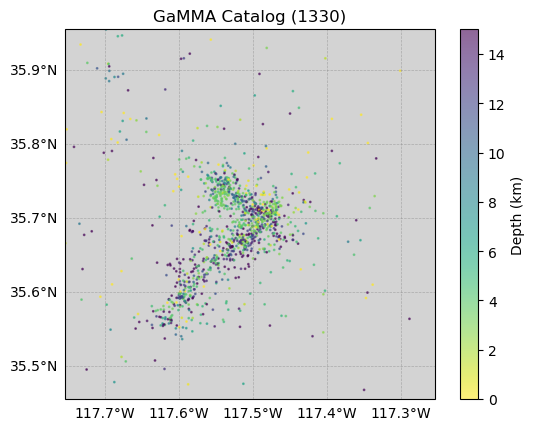

In [16]:
plot_catalog(gamma_catalog, "GaMMA", region=region, config=config)

### Run ADLoc to locate absolute earthquake locations

<img src="https://raw.githubusercontent.com/zhuwq0/images/main/202504062236724.png" style="width:50%;">

In [17]:
def run_adloc(root_path: str = "local", region: str = "demo", config: Dict = {}):

    data_path = f"{root_path}/{region}/gamma"
    result_path = f"{root_path}/{region}/adloc"
    figure_path = f"{root_path}/{region}/adloc/figures"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)

    picks_file = f"{data_path}/gamma_picks.csv"
    events_file = f"{data_path}/gamma_events.csv"
    stations_file = f"{root_path}/{region}/obspy/stations.json"

    proj = Proj(f"+proj=sterea +lon_0={config['longitude0']} +lat_0={config['latitude0']}  +units=km")

    ## read picks and associated events
    picks = pd.read_csv(picks_file)
    picks["phase_time"] = pd.to_datetime(picks["phase_time"])
     # drop unnecessary columns
    picks.drop(["id", "timestamp", "type", "amp", "prob", "event_idx"], axis=1, inplace=True, errors="ignore")
    if os.path.exists(events_file):
        events = pd.read_csv(events_file)
        events["time"] = pd.to_datetime(events["time"])
        events[["x_km", "y_km"]] = events.apply(
            lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1
        )
        events["z_km"] = events["depth_km"] if "depth_km" in events.columns else 10.0
    else:
        events = None

    ## read stations
    # stations = pd.read_csv(stations_file, sep="\t")
    stations = pd.read_json(stations_file, orient="index")
    stations["station_id"] = stations.apply(lambda x: f"{x['network']}.{x['station']}.{x['location']}.{x['channel'][:-1]}", axis=1)
    stations = stations.groupby("station_id").agg(lambda x: x.iloc[0] if len(set(x)) == 1 else sorted(list(x))).reset_index()
    stations["depth_km"] = -stations["elevation_m"] / 1000
    if "station_term_time_p" not in stations.columns:
        stations["station_term_time_p"] = 0.0
    if "station_term_time_s" not in stations.columns:
        stations["station_term_time_s"] = 0.0
    if "station_term_amplitude" not in stations.columns:
        stations["station_term_amplitude"] = 0.0
    stations[["x_km", "y_km"]] = stations.apply(
        lambda x: pd.Series(proj(longitude=x.longitude, latitude=x.latitude)), axis=1
    )
    stations["z_km"] = stations["elevation_m"].apply(lambda x: -x / 1e3)

    ## setting ADLoc configs
    config["use_amplitude"] = True

    minlat, maxlat = config["latitude0"] - config["maxradius_degree"], config["latitude0"] + config["maxradius_degree"]
    minlon, maxlon = config["longitude0"] - config["maxradius_degree"], config["longitude0"] + config["maxradius_degree"]
    xmin, ymin = proj(minlon, minlat)
    xmax, ymax = proj(maxlon, maxlat)
    zmin, zmax = config["mindepth"], config["maxdepth"]
    config["xlim_km"] = (xmin, xmax)
    config["ylim_km"] = (ymin, ymax)
    config["zlim_km"] = (zmin, zmax)

    ## Eikonal for 1D velocity model
    zz = [0.0, 5.5, 5.5, 16.0, 16.0, 32.0, 32.0]
    vp = [5.5, 5.5, 6.3, 6.3, 6.7, 6.7, 7.8]
    vp_vs_ratio = 1.73
    vs = [v / vp_vs_ratio for v in vp]
    # Northern California (Gil7)
    # zz = [0.0, 1.0, 3.0, 4.0, 5.0, 17.0, 25.0, 62.0]
    # vp = [3.2, 3.2, 4.5, 4.8, 5.51, 6.21, 6.89, 7.83]
    # vs = [1.5, 1.5, 2.4, 2.78, 3.18, 3.40, 3.98, 4.52]
    h = 0.3
    vel = {"Z": zz, "P": vp, "S": vs}
    config["eikonal"] = {
        "vel": vel,
        "h": h,
        "xlim_km": config["xlim_km"],
        "ylim_km": config["ylim_km"],
        "zlim_km": config["zlim_km"],
    }
    config["eikonal"] = init_eikonal2d(config["eikonal"])

    # RASAC
    config["min_picks"] = 6
    config["min_picks_ratio"] = 0.5
    config["max_residual_time"] = 1.0
    config["max_residual_amplitude"] = 1.0
    config["min_score"] = 0.5
    config["min_s_picks"] = 1.5
    config["min_p_picks"] = 1.5

    config["bfgs_bounds"] = (
        (config["xlim_km"][0] - 1, config["xlim_km"][1] + 1),  # x
        (config["ylim_km"][0] - 1, config["ylim_km"][1] + 1),  # y
        (0, config["zlim_km"][1] + 1),
        (None, None),  # t
    )

    # %%
    mapping_phase_type_int = {"P": 0, "S": 1}
    picks["phase_type"] = picks["phase_type"].map(mapping_phase_type_int)
    if "phase_amplitude" in picks.columns:
        picks["phase_amplitude"] = picks["phase_amplitude"].apply(lambda x: np.log10(x) + 2.0)  # convert to log10(cm/s)

    # %%
    stations["idx_sta"] = np.arange(len(stations))
    if events is None:
        picks = picks.merge(stations[["station_id", "x_km", "y_km", "z_km"]], on="station_id")
        events = picks.groupby("event_index").agg({"x_km": "mean", "y_km": "mean", "z_km": "mean", "phase_time": "min"})
        events["z_km"] = 10.0  # km default depth
        events.rename({"phase_time": "time"}, axis=1, inplace=True)
        events["event_index"] = events.index
        events.reset_index(drop=True, inplace=True)
        events["idx_eve"] = np.arange(len(events))
        picks.drop(["x_km", "y_km", "z_km"], axis=1, inplace=True)
    else:
        events["idx_eve"] = np.arange(len(events))

    picks = picks.merge(events[["event_index", "idx_eve"]], on="event_index")
    picks = picks.merge(stations[["station_id", "idx_sta"]], on="station_id")


    # for key, value in config.items():
    #     print(f"{key}: {value}")

    print(f"Number of picks: {len(picks)}")
    print(f"Number of events: {len(events)}")

    # %%
    estimator = ADLoc(config, stations=stations[["x_km", "y_km", "z_km"]].values, eikonal=config["eikonal"])

    # %%
    MAX_SST_ITER = 8
    events_init = events.copy()

    for iter in range(MAX_SST_ITER):
        picks, events = invert_location(picks, stations, config, estimator, events_init=events_init, iter=iter)

        station_term_amp = (
            picks[picks["mask"] == 1.0].groupby("idx_sta").agg({"residual_amplitude": "median"}).reset_index()
        )
        station_term_amp.set_index("idx_sta", inplace=True)
        stations["station_term_amplitude"] += stations["idx_sta"].map(station_term_amp["residual_amplitude"]).fillna(0)

        station_term_time = (
            picks[picks["mask"] == 1.0].groupby(["idx_sta", "phase_type"]).agg({"residual_time": "mean"}).reset_index()
        )
        station_term_time.set_index("idx_sta", inplace=True)
        stations["station_term_time_p"] += (
            stations["idx_sta"].map(station_term_time[station_term_time["phase_type"] == 0]["residual_time"]).fillna(0)
        )
        stations["station_term_time_s"] += (
            stations["idx_sta"].map(station_term_time[station_term_time["phase_type"] == 1]["residual_time"]).fillna(0)
        )

        if "event_index" not in events.columns:
            events["event_index"] = events.merge(picks[["idx_eve", "event_index"]], on="idx_eve")["event_index"]
        events[["longitude", "latitude"]] = events.apply(
            lambda x: pd.Series(proj(x["x_km"], x["y_km"], inverse=True)), axis=1
        )
        events["depth_km"] = events["z_km"]

        picks["adloc_mask"] = picks["mask"]
        picks["adloc_residual_time"] = picks["residual_time"]
        picks["adloc_residual_amplitude"] = picks["residual_amplitude"]

        picks.to_csv(os.path.join(result_path, f"adloc_picks_sst_{iter}.csv"), index=False)
        events.to_csv(os.path.join(result_path, f"adloc_events_sst_{iter}.csv"), index=False)
        stations.to_csv(os.path.join(result_path, f"adloc_stations_sst_{iter}.csv"), index=False)

    # %%
    if "event_index" not in events.columns:
        events["event_index"] = events.merge(picks[["idx_eve", "event_index"]], on="idx_eve")["event_index"]
    events[["longitude", "latitude"]] = events.apply(
        lambda x: pd.Series(proj(x["x_km"], x["y_km"], inverse=True)), axis=1
    )
    events["depth_km"] = events["z_km"]
    events.drop(["idx_eve", "x_km", "y_km", "z_km"], axis=1, inplace=True, errors="ignore")
    events.sort_values(["time"], inplace=True)

    picks["phase_type"] = picks["phase_type"].map({0: "P", 1: "S"})
    picks.drop(
        ["idx_eve", "idx_sta", "mask", "residual_time", "residual_amplitude"], axis=1, inplace=True, errors="ignore"
    )
    picks.sort_values(["phase_time"], inplace=True)

    stations.drop(["idx_sta", "x_km", "y_km", "z_km"], axis=1, inplace=True, errors="ignore")

    picks.to_csv(os.path.join(result_path, "adloc_picks.csv"), index=False)
    events.to_csv(os.path.join(result_path, "adloc_events.csv"), index=False)
    stations.to_csv(os.path.join(result_path, "adloc_stations.csv"), index=False)

    return events

In [18]:
adloc_catalog = run_adloc(region=region, config=config)

Eikonal Solver: 
Iter 0, error = 999.945
Iter 1, error = 0.000
Time: 1.913
Eikonal Solver: 
Iter 0, error = 999.906
Iter 1, error = 0.000
Time: 0.046
Number of picks: 25234
Number of events: 1330


Iter 0: 100%|██████████| 1330/1330 [01:18<00:00, 16.97it/s]

ADLoc locates 1064 events outof 1330 events
using 22740 picks outof 25234 picks



Iter 1: 100%|██████████| 1330/1330 [01:15<00:00, 17.56it/s]

ADLoc locates 1047 events outof 1330 events
using 22558 picks outof 25234 picks



Iter 2: 100%|██████████| 1330/1330 [01:15<00:00, 17.56it/s]

ADLoc locates 1042 events outof 1330 events
using 22494 picks outof 25234 picks



Iter 3: 100%|██████████| 1330/1330 [01:16<00:00, 17.46it/s]

ADLoc locates 1042 events outof 1330 events
using 22495 picks outof 25234 picks



Iter 4: 100%|██████████| 1330/1330 [01:16<00:00, 17.45it/s]

ADLoc locates 1037 events outof 1330 events
using 22401 picks outof 25234 picks



Iter 5: 100%|██████████| 1330/1330 [01:16<00:00, 17.30it/s]

ADLoc locates 1040 events outof 1330 events
using 22469 picks outof 25234 picks



Iter 6: 100%|██████████| 1330/1330 [01:16<00:00, 17.41it/s]

ADLoc locates 1041 events outof 1330 events
using 22490 picks outof 25234 picks



Iter 7: 100%|██████████| 1330/1330 [01:15<00:00, 17.68it/s]

ADLoc locates 1042 events outof 1330 events
using 22472 picks outof 25234 picks


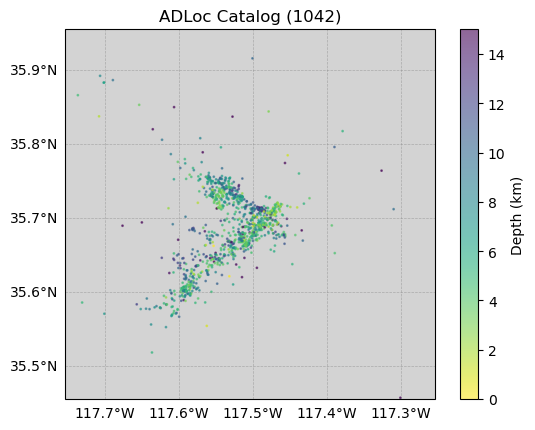

In [19]:
plot_catalog(adloc_catalog, "ADLoc", region=region, config=config)

### Run HypoDD to relocate relative earthquake locations

<img src="https://raw.githubusercontent.com/zhuwq0/images/main/202504062239659.png" style="width:40%;">
<br>
<img src="https://raw.githubusercontent.com/zhuwq0/images/main/202504062241134.png" style="width:30%;">

In [20]:
def run_hypodd(root_path: str = "local", region: str = "demo"):

    data_path = f"{region}/adloc"
    result_path = f"{region}/hypodd"
    if not os.path.exists(f"{root_path}/{result_path}"):
        os.makedirs(f"{root_path}/{result_path}")

    ## Station Format
    stations = pd.read_csv(f"{root_path}/{data_path}/adloc_stations.csv")
    stations.set_index("station_id", inplace=True)

    shift_topo = stations["elevation_m"].max() / 1e3
    converted_hypoinverse = []
    converted_hypodd = {}

    for sta, row in stations.iterrows():
        network_code, station_code, comp_code, channel_code = sta.split(".")
        station_weight = " "
        lat_degree = int(row["latitude"])
        lat_minute = (row["latitude"] - lat_degree) * 60
        north = "N" if lat_degree >= 0 else "S"
        lng_degree = int(row["longitude"])
        lng_minute = (row["longitude"] - lng_degree) * 60
        west = "W" if lng_degree <= 0 else "E"
        elevation = row["elevation_m"]
        line_hypoinverse = f"{station_code:<5} {network_code:<2} {comp_code[:-1]:<1}{channel_code:<3} {station_weight}{abs(lat_degree):2.0f} {abs(lat_minute):7.4f}{north}{abs(lng_degree):3.0f} {abs(lng_minute):7.4f}{west}{elevation:4.0f}\n"
        converted_hypoinverse.append(line_hypoinverse)

        # tmp_code = f"{station_code}{channel_code}"
        tmp_code = f"{station_code}"
        converted_hypodd[tmp_code] = f"{tmp_code:<8s} {row['latitude']:.3f} {row['longitude']:.3f}\n"


    with open(f"{root_path}/{result_path}/stations.dat", "w") as f:
        for k, v in converted_hypodd.items():
            f.write(v)


    ## Picks Format
    picks_csv = f"{data_path}/adloc_picks.csv"
    events_csv = f"{data_path}/adloc_events.csv"

    picks = pd.read_csv(f"{root_path}/{picks_csv}")
    events = pd.read_csv(f"{root_path}/{events_csv}")
    picks["phase_time"] = pd.to_datetime(picks["phase_time"], format="mixed")
    events["time"] = pd.to_datetime(events["time"])
    # events["magnitude"] = 1.0
    events["sigma_time"] = 1.0

    # events.sort_values("time", inplace=True)
    picks = picks.loc[picks["event_index"].isin(events["event_index"])]

    lines = []
    picks_by_event = picks.groupby("event_index").groups
    for i, event in tqdm(events.iterrows(), desc="Convert catalog", total=len(events)):
        # event_time = datetime.strptime(event["time"], "%Y-%m-%dT%H:%M:%S.%f")
        event_time = event["time"]
        lat = event["latitude"]
        lng = event["longitude"]
        # dep = event["depth(m)"] / 1e3 + shift_topo
        dep = event["depth_km"] + shift_topo
        mag = event["magnitude"]
        EH = 0
        EZ = 0
        RMS = event["sigma_time"]

        year, month, day, hour, min, sec = (
            event_time.year,
            event_time.month,
            event_time.day,
            event_time.hour,
            event_time.minute,
            float(event_time.strftime("%S.%f")),
        )
        event_line = f"# {year:4d} {month:2d} {day:2d} {hour:2d} {min:2d} {sec:5.2f}  {lat:7.4f} {lng:9.4f}   {dep:5.2f} {mag:5.2f} {EH:5.2f} {EZ:5.2f} {RMS:5.2f} {event['event_index']:9d}\n"

        lines.append(event_line)

        picks_idx = picks_by_event[event["event_index"]]
        for j in picks_idx:
            # pick = picks.iloc[j]
            pick = picks.loc[j]
            network_code, station_code, comp_code, channel_code = pick["station_id"].split(".")
            phase_type = pick["phase_type"].upper()
            phase_score = pick["phase_score"]
            # pick_time = (datetime.strptime(pick["phase_time"], "%Y-%m-%dT%H:%M:%S.%f") - event_time).total_seconds()
            pick_time = (pick["phase_time"] - event_time).total_seconds()
            tmp_code = f"{station_code}"
            pick_line = f"{tmp_code:<7s}   {pick_time:6.3f}   {phase_score:5.4f}   {phase_type}\n"
            lines.append(pick_line)

    with open(f"{root_path}/{result_path}/phase.txt", "w") as fp:
        fp.writelines(lines)

    ## Run Hypodd
    print(f"Running Hypodd:")
    os.system(f"bash run_hypodd_ct.sh {root_path} {region}")

    ## Read  catalog
    columns = ["ID", "LAT", "LON", "DEPTH", "X", "Y", "Z", "EX", "EY", "EZ", "YR", "MO", "DY", "HR", "MI", "SC", "MAG", "NCCP", "NCCS", "NCTP", "NCTS", "RCC", "RCT", "CID"]
    catalog_ct_hypodd = pd.read_csv(f"{root_path}/{region}/hypodd/hypodd_ct.reloc", sep="\s+", header=None, names=columns, dtype=float)
    catalog_ct_hypodd["time"] = catalog_ct_hypodd.apply(
        lambda x: f'{x["YR"]:04.0f}-{x["MO"]:02.0f}-{x["DY"]:02.0f}T{x["HR"]:02.0f}:{x["MI"]:02.0f}:{np.min([float(x["SC"]), 59.999]):05.3f}',
        axis=1,
    )
    catalog_ct_hypodd["time"] = catalog_ct_hypodd["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
    catalog_ct_hypodd = catalog_ct_hypodd[catalog_ct_hypodd["DEPTH"] != "*********"]
    catalog_ct_hypodd["DEPTH"] = catalog_ct_hypodd["DEPTH"].astype(float)
    catalog_ct_hypodd.rename({"ID": "event_index", "LAT": "latitude", "LON": "longitude", "DEPTH": "depth_km", "MAG": "magnitude"}, axis=1, inplace=True)
    catalog_ct_hypodd.to_csv(f"{root_path}/{region}/hypodd/hypodd_ct.csv", index=False)

    return catalog_ct_hypodd

In [21]:
hypodd_catalog = run_hypodd(region=region)

Convert catalog: 100%|██████████| 1042/1042 [00:02<00:00, 493.90it/s]
+ WORKING_DIR=/workspaces/Earthquake_Catalog_Workshop/notebooks
+ '[' 2 -eq 2 ']'
+ root_path=local
+ region=demo
+ data_path=local/demo/hypodd
+ '[' '!' -d local/demo/hypodd ']'
+ cd local/demo/hypodd
+ '[' '!' -d HypoDD ']'
+ cat
+ cat
+ ./HypoDD/src/ph2dt/ph2dt ph2dt.inp


Running Hypodd:
starting ph2dt (v2.1b - 08/2012)...     Mon Apr  7 05:07:45 2025 

reading data ...
 > stations =           15
 > events total =         1042
 > events selected =         1007
 > phases =        22785
forming dtimes...
 > stations selected =           14
 > P-phase pairs total =       278954
 > S-phase pairs total =       305503
 > outliers =        22439  (           3 %)
 > phases at stations not in station list =            0
 > phases at distances larger than MAXDIST =            0
 > P-phase pairs selected =       246261  (          88 %)
 > S-phase pairs selected =       278120  (          91 %)
 > weakly linked events =           49  (           4 %)
 > linked event pairs =        30308
 > average links per pair =           17
 > average offset (km) betw. linked events =    2.60961533    
 > average offset (km) betw. strongly linked events =    2.60961533    
 > maximum offset (km) betw. strongly linked events =    9.99335098    

Done.  Mon Apr  7 05:07:46 2025 

+ ./HypoDD/src/hypoDD/hypoDD ct.inp


# catalog P dtimes =  246261
# catalog S dtimes =  278120
# dtimes total =   524381
# events after dtime match =        991
# stations =     14

no clustering performed.

RELOCATION OF CLUSTER: 1     Mon Apr  7 05:07:48 2025
----------------------
Initial trial sources =   991
1D ray tracing.

  IT   EV  CT    RMSCT   RMSST   DX   DY   DZ   DT   OS  AQ  CND
        %   %   ms     %    ms    m    m    m   ms    m 
 1    100  99  155 -11.7     0  244  199 2239   66    0  25  265
 2     97  97  153  -1.8     0  240  193 1623   62    0   1  264
 3  1  97  97  151  -0.9   313  242  194 1611   62  459   0  264
 4     97  95  133 -12.3   313  161  113  632   31  459  12  308
 5  2  96  93  129  -2.7   275  157  112  558   30   71   0  307
 6     96  92  115 -10.8   275  111   71  627   19   71   8  283
 7  3  95  91  113  -1.6   255  109   71  526   18  298   0  286
 8     95  90  107  -5.3   255   91   51  608   16  298   6  270
 9  4  95  89  106  -0.9   244   91   52  530   16  639   0  2

+ cd /workspaces/Earthquake_Catalog_Workshop/notebooks


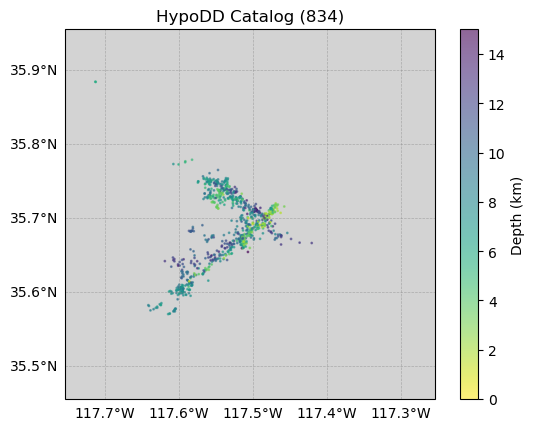

In [22]:
plot_catalog(hypodd_catalog, "HypoDD", region=region, config=config)